In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
 import datetime as dt

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import *
#create_engine, func

In [5]:
 engine = create_engine("sqlite:///hawaii.sqlite")

##  Step 1 - Climate Analysis and Exploration

In [6]:
 # reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

# reflect the tables
meta = MetaData()
meta.reflect(bind=engine)
measurement_table = meta.tables['measurement']
station_table = meta.tables['station']


In [7]:
 # We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
 # Save references to each table
Measurement = Base.classes.measurement
Station= Base.classes.station

In [9]:


inspector = inspect(engine)
inspector.get_table_names()

columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'],c['type'])
engine.execute('SELECT * FROM station').fetchall()

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

  ## Precipitation Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#Select only the date and prcp values.

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print("The last data point in the database was on: ", last_date)

oneyear_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", oneyear_date)


prcp_12 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').order_by(Measurement.date).all()

#Load the query results into a Pandas DataFrame and set the index to the date column.

prcp12_df = pd.DataFrame(prcp_12)
prcp12_df.reset_index(level=0, inplace=True)
prcp12_df = prcp12_df[['date', 'prcp']]
prcp12_df

precipitation_df = prcp12_df.dropna(axis=0,how='any')
precipitation_df

#Sort the DataFrame values by date.

precipitation_df = precipitation_df.sort_values(by = 'date', ascending = False)
precipitation_df


The last data point in the database was on:  ('2017-08-23',)
Query Date:  2016-08-23


,date,prcp
2229,2017-08-23,0.45
2228,2017-08-23,0.08
2227,2017-08-23,0.00
2226,2017-08-23,0.00
2225,2017-08-22,0.50
...,...,...
2,2016-08-23,0.05
1,2016-08-23,0.15
5,2016-08-23,1.79
6,2016-08-23,0.70


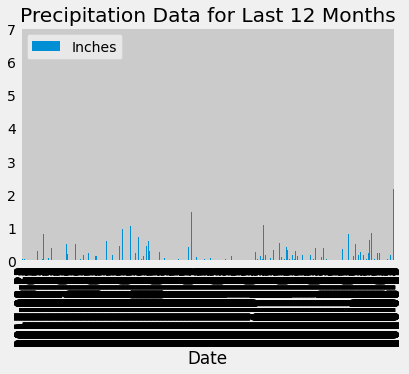

<Figure size 360x720 with 0 Axes>

In [13]:
#Plot the results using the DataFrame plot method.

date_prcp = precipitation_df['date'].values.tolist()
date_prcp

prcp = precipitation_df['prcp'].values.tolist()
prcp

data = {"Date": date_prcp,
        "Inches": prcp};

dataFrame = pd.DataFrame(data = data)

dataFrame.plot.bar(x="Date", y="Inches", title="Precipitation Data for Last 12 Months")
plt.figure(figsize=(5,10))
plt.show()


In [14]:
#Use Pandas to print the summary statistics for the precipitation data.
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [15]:
"""
Design a query to calculate the total number of stations.
    -List the stations and observation counts in descending order.
    -Which station has the highest number of observations?
Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.
"""
session=Session(engine)
stations = session.query(Station.station).count()
print(f"There are {stations} stations.")

observation = session.query(Measurement.station, Measurement.tobs).\
    order_by(Measurement.tobs.desc()).all()
observation 


There are 9 stations.


[('USC00519397', 87.0),
 ('USC00519397', 87.0),
 ('USC00517948', 87.0),
 ('USC00511918', 87.0),
 ('USC00511918', 86.0),
 ('USC00511918', 86.0),
 ('USC00511918', 86.0),
 ('USC00511918', 86.0),
 ('USC00519397', 85.0),
 ('USC00519397', 85.0),
 ('USC00513117', 85.0),
 ('USC00513117', 85.0),
 ('USC00514830', 85.0),
 ('USC00519523', 85.0),
 ('USC00519281', 85.0),
 ('USC00511918', 85.0),
 ('USC00511918', 85.0),
 ('USC00511918', 85.0),
 ('USC00511918', 85.0),
 ('USC00519397', 84.0),
 ('USC00519397', 84.0),
 ('USC00519397', 84.0),
 ('USC00519397', 84.0),
 ('USC00519397', 84.0),
 ('USC00513117', 84.0),
 ('USC00513117', 84.0),
 ('USC00513117', 84.0),
 ('USC00513117', 84.0),
 ('USC00513117', 84.0),
 ('USC00514830', 84.0),
 ('USC00514830', 84.0),
 ('USC00517948', 84.0),
 ('USC00517948', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523', 84.0),
 ('USC00519523',

In [19]:
"""
-Which station has the highest number of observations?
Hint: You may need to use functions such as func.min, func.max, func.avg, and func.count in your queries.
"""
from sqlalchemy import func

high =session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).all()
print("USC00519281 has the highest number of observations")
high

USC00519281 has the highest number of observations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
"""
Design a query to retrieve the last 12 months of temperature observation data (TOBS).
    -Filter by the station with the highest number of observations.
"""


'\nDesign a query to retrieve the last 12 months of temperature observation data (TOBS).\n    -Filter by the station with the highest number of observations.\n'

In [18]:
"""
Plot the results as a histogram with bins=12.
"""

'\nPlot the results as a histogram with bins=12.\n'

## Step 2 - Climate App

In [19]:
"""
Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.
Use Flask to create your routes.

Routes:
/
    -Home page.
    -List all routes that are available.
"""



'\nNow that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.\nUse Flask to create your routes.\n\nRoutes:\n/\n    -Home page.\n    -List all routes that are available.\n'

In [20]:
"""
/api/v1.0/precipitation
    -Convert the query results to a dictionary using date as the key and prcp as the value.
    -Return the JSON representation of your dictionary.
"""




'\n/api/v1.0/precipitation\n    -Convert the query results to a dictionary using date as the key and prcp as the value.\n    -Return the JSON representation of your dictionary.\n'

In [21]:
"""
/api/v1.0/stations
    -Return a JSON list of stations from the dataset.
"""



'\n/api/v1.0/stations\n    -Return a JSON list of stations from the dataset.\n'

In [22]:
"""
/api/v1.0/tobs
    -Query the dates and temperature observations of the most active station for the last year of data.
    -Return a JSON list of temperature observations (TOBS) for the previous year.
"""



'\n/api/v1.0/tobs\n    -Query the dates and temperature observations of the most active station for the last year of data.\n    -Return a JSON list of temperature observations (TOBS) for the previous year.\n'

In [23]:
"""
/api/v1.0/<start> and /api/v1.0/<start>/<end>
    -Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start 
     or start-end range.
    -When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
    -When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and 
     end date inclusive.
"""



'\n/api/v1.0/<start> and /api/v1.0/<start>/<end>\n    -Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start \n     or start-end range.\n    -When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.\n    -When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and \n     end date inclusive.\n'

  ## Bonus Challenge Assignment

### Temperature Analysis I

In [24]:
"""
Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, 
for example, June and December?
"""




'\nHawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, \nfor example, June and December?\n'

In [25]:
"""
You may either use SQLAlchemy or pandas's read_csv() to perform this portion.
Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
"""



"\nYou may either use SQLAlchemy or pandas's read_csv() to perform this portion.\nIdentify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.\n"

In [26]:
"""
Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
"""




'\nUse the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?\n'

### Temperature Analysis II

In [27]:
"""
The starter notebook contains a function called calc_temps that will accept a start date and end date in the 
format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.

"""

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
"""
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates 
from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").
"""



'\nUse the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates \nfrom the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").\n'

In [29]:
"""
Plot the min, avg, and max temperature from your previous query as a bar chart.
    -Use the average temperature as the bar height(y value).
    -Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).
    -Use "Trip Avg Temp" as your Title
"""



'\nPlot the min, avg, and max temperature from your previous query as a bar chart.\n    -Use the average temperature as the bar height(y value).\n    -Use the peak-to-peak (TMAX-TMIN) value as the y error bar (YERR).\n    -Use "Trip Avg Temp" as your Title\n'

### Daily Rainfall Average

In [30]:
"""
Calculate the rainfall per weather station using the previous year's matching dates.
"""


"\nCalculate the rainfall per weather station using the previous year's matching dates.\n"

In [31]:
"""
Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.
"""



'\nCalculate the daily normals. Normals are the averages for the min, avg, and max temperatures.\n'

In [32]:
"""
You are provided with a function called daily_normals that will calculate the daily normals for a specific date. 
This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.
"""

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
"""
Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals 
for each date string and append the results to a list.

"""


'\nCreate a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals \nfor each date string and append the results to a list.\n\n'

In [34]:
"""
Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
"""

'\nLoad the list of daily normals into a Pandas DataFrame and set the index equal to the date.\n'

In [35]:
"""
Use Pandas to plot an area plot (stacked=False) for the daily normals.
"""

'\nUse Pandas to plot an area plot (stacked=False) for the daily normals.\n'